In [45]:
import sys
print("Python Version:", sys.version)
import statistics
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_rows', 500)
%config InlineBackend.figure_format = 'svg'
%matplotlib inline
sns.set()

import scipy.stats as scs
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.datasets import make_classification
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve

import warnings
warnings.filterwarnings('ignore')

Python Version: 3.7.7 (default, Mar 23 2020, 17:31:31) 
[Clang 4.0.1 (tags/RELEASE_401/final)]


In [27]:
df_raw_wine = pd.read_csv('Wine_Data/kaggle_wine.csv')
df_wine = df_raw_wine.iloc[:,1:]
len(df_wine)

150930

In [28]:
df_wine.head()

,country,description,designation,points,price,province,region_1,region_2,variety,winery
0,US,This tremendous 100% varietal wine hails from ...,Martha's Vineyard,96,235.0,California,Napa Valley,Napa,Cabernet Sauvignon,Heitz
1,Spain,"Ripe aromas of fig, blackberry and cassis are ...",Carodorum Selección Especial Reserva,96,110.0,Northern Spain,Toro,NaN,Tinta de Toro,Bodega Carmen Rodríguez
2,US,Mac Watson honors the memory of a wine once ma...,Special Selected Late Harvest,96,90.0,California,Knights Valley,Sonoma,Sauvignon Blanc,Macauley
3,US,"This spent 20 months in 30% new French oak, an...",Reserve,96,65.0,Oregon,Willamette Valley,Willamette Valley,Pinot Noir,Ponzi
4,France,"This is the top wine from La Bégude, named aft...",La Brûlade,95,66.0,Provence,Bandol,NaN,Provence red blend,Domaine de la Bégude


In [29]:
df_wine['description'][0]

'This tremendous 100% varietal wine hails from Oakville and was aged over three years in oak. Juicy red-cherry fruit and a compelling hint of caramel greet the palate, framed by elegant, fine tannins and a subtle minty tone in the background. Balanced and rewarding from start to finish, it has years ahead of it to develop further nuance. Enjoy 2022–2030.'

The Most important data from this data set seems to be the description.

In [30]:
df_us = df_wine[df_wine['country'] == 'US']
df_fr = df_wine[df_wine['country'] == 'France']
df_wine2 = pd.concat([df_us, df_fr])
df_wine2.reset_index(drop = True, inplace = True)

To make this a manageable process, we will stick to United States vs. France in a traditional Old World vs. New World cook-off. We will try to classify based on descriptions and scores.  

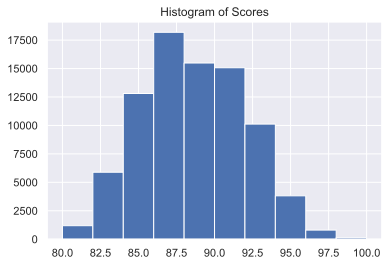

In [31]:
plt.hist(df_wine2.points)
plt.title('Histogram of Scores');

The scores look fairly normal here.

In [32]:
grapes = df_wine2['variety'].value_counts()
grapes.head()

Pinot Noir                  12413
Chardonnay                  11019
Cabernet Sauvignon           9228
Bordeaux-style Red Blend     6792
Syrah                        4732
Name: variety, dtype: int64

Just to keep the problem simple at first, we will try to stick to one grape. Chardonnay seems to have plenty of data and is well split up. With some domain knowledge (if appreciating wine is knowledge),we should go ahead and check the grape types for any appelations that may be Chardonnay grapes produced in certain regions of France. As you can see below, we sifted through the grape types and they have already set everything to its common grape type name. 

In [33]:
df_chard = df_wine2[df_wine2['variety'] == 'Chardonnay']
df_chard.reset_index(drop = True, inplace = True)
df_chard['country'].value_counts()

US        8127
France    2892
Name: country, dtype: int64

This looks like the scores are fairly normal. As a test, lets add columns that are binary. 1 if the description contains a given word and 0 if it does not. Our goal here is to quantify the dscription section using some keywords.

In [34]:
#Here are some functions to pull words from descriptions
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
def oak_finder(description):
    string = description.lower()
    num = string.find(' oak')
    if num == -1:
        return 0
    else: 
        return 1
def wood_finder(description):
    string = description.lower()
    num = string.find('wood')
    if num == -1:
        return 0
    else: 
        return 1
def tannin_finder(description):
    string = description.lower()
    num = string.find('tannin')
    if num == -1:
        return 0
    else: 
        return 1
def metal_finder(description):
    string = description.lower()
    num = string.find('steel')
    num2 = string.find('metal')
    if num == -1 and num2 == -1:
        return 0
    else: 
        return 1
def spice_finder(description):
    string = description.lower()
    num = string.find('spice')
    num2 = string.find('spicy')
    if num == -1 and  num2 == -1:
        return 0
    else: 
        return 1
def butter_finder(description):
    string = description.lower()
    num = string.find('butter')
    num2 = string.find('cream')
    if num == -1 and num == -1:
        return 0
    else: 
        return 1
def mineral_finder(description):
    string = description.lower()
    num = string.find('mineral')
    if num == -1:
        return 0
    else: 
        return 1
def limestone_finder(description):
    string = description.lower()
    num = string.find('stone')
    if num == -1:
        return 0
    else: 
        return 1
def chalk_finder(description):
    string = description.lower()
    num = string.find('chalk')
    if num == -1:
        return 0
    else: 
        return 1
def citrus_finder(description):
    string = description.lower()
    num = string.find('citrus')
    if num == -1:
        return 0
    else: 
        return 1
def lemon_finder(description):
    string = description.lower()
    num2 = string.find('lemon')
    if num2 == -1:
        return 0
    else: 
        return 1
def orange_finder(description):
    string = description.lower()
    num2 = string.find('orange')
    if num2 == -1:
        return 0
    else: 
        return 1
def floral_finder(description):
    string = description.lower()
    num2 = string.find('floral')
    if num2 == -1:
        return 0
    else: 
        return 1
def acidic_finder(description):
    string = description.lower()
    num = string.find('acidic')
    num2 = string.find('acidity')
    if num == -1 and num2 == -1:
        return 0
    else: 
        return 1
def bold_finder(description):
    string = description.lower()
    num = string.find('bold')
    num2 = string.find('big')
    if num == -1 and num2 == -1:
        return 0
    else: 
        return 1
def rich_finder(description):
    string = description.lower()
    num = string.find('rich')
    if num == -1:
        return 0
    else: 
        return 1
def subtle_finder(description):
    string = description.lower()
    num = string.find('subtle')
    if num == -1:
        return 0
    else: 
        return 1
def light_finder(description):
    string = description.lower()
    num = string.find('light')
    num2 = string.find('gentle')
    if num == -1 and num2 == -1:
        return 0
    else: 
        return 1
def fruit_finder(description):
    string = description.lower()
    num = string.find('fruit')
    if num == -1:
        return 0
    else: 
        return 1
def earth_finder(description):
    string = description.lower()
    num = string.find('earth')
    num2 = string.find('dirt')
    if num == -1 and num2 == -1:
        return 0
    else: 
        return 1
def ripe_finder(description):
    string = description.lower()
    num = string.find('ripe')
    if num == -1:
        return 0
    else: 
        return 1
def smoke_finder(description):
    string = description.lower()
    num = string.find('smoke')
    if num == -1:
        return 0
    else: 
        return 1
def apple_finder(description):
    string = description.lower()
    num = string.find('apple')
    num2 = string.find(' pear')
    if num == -1 and num2 == -1:
        return 0
    else: 
        return 1
def nut_finder(description):
    string = description.lower()
    num = string.find('nut')
    if num == -1:
        return 0
    else: 
        return 1
def petrol_finder(description):
    string = description.lower()
    num = string.find('petrol')
    if num == -1:
        return 0
    else: 
        return 1
def ethanol_finder(description):
    string = description.lower()
    num = string.find('ethanol')
    if num == -1:
        return 0
    else: 
        return 1
def vanilla_finder(description):
    string = description.lower()
    num = string.find('vanilla')
    if num == -1:
        return 0
    else: 
        return 1
def tobacco_finder(description):
    string = description.lower()
    num = string.find('tobacco')
    if num == -1:
        return 0
    else: 
        return 1
def leather_finder(description):
    string = description.lower()
    num = string.find('leather')
    if num == -1:
        return 0
    else: 
        return 1
def cheese_finder(description):
    string = description.lower()
    num = string.find('cheese')
    num2 = string.find('rind')
    if num == -1 and num2 == -1:
        return 0
    else: 
        return 1
def coconut_finder(description):
    string = description.lower()
    num = string.find('coconut')
    if num == -1:
        return 0
    else: 
        return 1
def salt_finder(description):
    string = description.lower()
    num = string.find('salt')
    num2 = string.find('salinity')
    if num == -1 and num2 == -1:
        return 0
    else: 
        return 1
def crisp_finder(description):
    string = description.lower()
    num = string.find('crisp')
    if num == -1:
        return 0
    else: 
        return 1
def clean_finder(description):
    string = description.lower()
    num = string.find('clean')
    if num == -1:
        return 0
    else: 
        return 1
def tropical_finder(description):
    string = description.lower()
    num = string.find('tropical')
    if num == -1:
        return 0
    else: 
        return 1
def baking_spices_finder(description):
    string = description.lower()
    num = string.find('baking spices')
    if num == -1:
        return 0
    else: 
        return 1
def cinnamon_finder(description):
    string = description.lower()
    num = string.find('cinnamon')
    if num == -1:
        return 0
    else: 
        return 1
def nutmeg_finder(description):
    string = description.lower()
    num = string.find('nutmeg')
    if num == -1:
        return 0
    else: 
        return 1
def peach_finder(description):
    string = description.lower()
    num = string.find('peach')
    if num == -1:
        return 0
    else: 
        return 1
def pineapple_finder(description):
    string = description.lower()
    num = string.find('pineapple')
    if num == -1:
        return 0
    else: 
        return 1
def papaya_finder(description):
    string = description.lower()
    num = string.find('papaya')
    if num == -1:
        return 0
    else: 
        return 1
def sharp_finder(description):
    string = description.lower()
    num = string.find('sharp')
    if num == -1:
        return 0
    else: 
        return 1
def dull_finder(description):
    string = description.lower()
    num = string.find('dull')
    if num == -1:
        return 0
    else: 
        return 1
def grass_finder(description):
    string = description.lower()
    num = string.find('grass')
    if num == -1:
        return 0
    else: 
        return 1
def licorice_finder(description):
    string = description.lower()
    num = string.find('licorice')
    if num == -1:
        return 0
    else: 
        return 1
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~    
    
    
#Add columns:
df_chard['oak'] = df_chard['description'].apply(oak_finder)
df_chard['wood'] = df_chard['description'].apply(wood_finder)
df_chard['tannin'] = df_chard['description'].apply(tannin_finder)
df_chard['metal'] = df_chard['description'].apply(metal_finder)
df_chard['spice'] = df_chard['description'].apply(spice_finder)
df_chard['butter'] = df_chard['description'].apply(butter_finder)
df_chard['mineral'] = df_chard['description'].apply(mineral_finder)
df_chard['limestone'] = df_chard['description'].apply(limestone_finder)
df_chard['chalk'] = df_chard['description'].apply(chalk_finder)
df_chard['citrus'] = df_chard['description'].apply(citrus_finder)
df_chard['lemon'] = df_chard['description'].apply(lemon_finder)
df_chard['orange'] = df_chard['description'].apply(orange_finder)
df_chard['floral'] = df_chard['description'].apply(floral_finder)
df_chard['acidic'] = df_chard['description'].apply(acidic_finder)
df_chard['bold'] = df_chard['description'].apply(bold_finder)
df_chard['rich'] = df_chard['description'].apply(rich_finder)
df_chard['subtle'] = df_chard['description'].apply(subtle_finder)
df_chard['light'] = df_chard['description'].apply(light_finder)
df_chard['fruit'] = df_chard['description'].apply(fruit_finder)
df_chard['earth'] = df_chard['description'].apply(earth_finder)
df_chard['ripe'] = df_chard['description'].apply(ripe_finder)
df_chard['smoke'] = df_chard['description'].apply(smoke_finder)
df_chard['apple'] = df_chard['description'].apply(apple_finder)
df_chard['nut'] = df_chard['description'].apply(nut_finder)
df_chard['petrol'] = df_chard['description'].apply(petrol_finder)
df_chard['ethanol'] = df_chard['description'].apply(ethanol_finder)
df_chard['vanilla'] = df_chard['description'].apply(vanilla_finder)
df_chard['tobacco'] = df_chard['description'].apply(tobacco_finder)
df_chard['leather'] = df_chard['description'].apply(leather_finder)
df_chard['cheese'] = df_chard['description'].apply(cheese_finder)
df_chard['coconut'] = df_chard['description'].apply(coconut_finder)
df_chard['salt'] = df_chard['description'].apply(salt_finder)
df_chard['crisp'] = df_chard['description'].apply(crisp_finder)
df_chard['clean'] = df_chard['description'].apply(clean_finder)
df_chard['tropical'] = df_chard['description'].apply(tropical_finder)
df_chard['baking spices'] = df_chard['description'].apply(baking_spices_finder)
df_chard['cinnamon'] = df_chard['description'].apply(cinnamon_finder)
df_chard['nutmeg'] = df_chard['description'].apply(nutmeg_finder)
df_chard['peach'] = df_chard['description'].apply(nutmeg_finder)
df_chard['pineapple'] = df_chard['description'].apply(pineapple_finder)
df_chard['papaya'] = df_chard['description'].apply(papaya_finder)
df_chard['sharp'] = df_chard['description'].apply(sharp_finder)
df_chard['dull'] = df_chard['description'].apply(dull_finder)
df_chard['grass'] = df_chard['description'].apply(grass_finder)
df_chard['licorice'] = df_chard['description'].apply(licorice_finder)

In [35]:
binary_features = df_chard.iloc[:,10:]
target = df_chard['country']
binary_features.head()

,oak,wood,tannin,metal,spice,butter,mineral,limestone,chalk,citrus,...,baking spices,cinnamon,nutmeg,peach,pineapple,papaya,sharp,dull,grass,licorice
0,0,0,0,0,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [36]:
X_train, X_test, y_train, y_test = train_test_split(binary_features,target,test_size = 0.15)


knn = KNeighborsClassifier(n_neighbors=7)
knn.fit(X_train,y_train)

KNeighborsClassifier(n_neighbors=7)

In [37]:
knn.score(X_train,y_train)

0.9067905188981422

In [38]:
knn.score(X_test,y_test)

0.8711433756805808

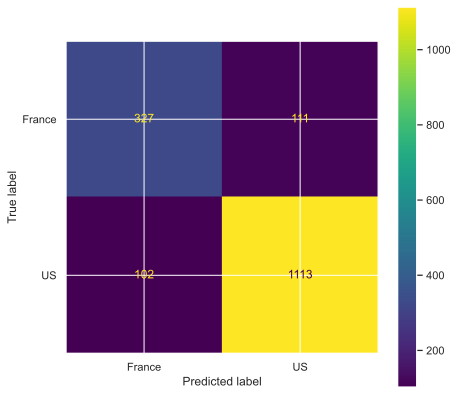

In [39]:
fig, ax = plt.subplots(figsize=(7, 7))
plot_confusion_matrix(knn, X_test, y_test, ax=ax);

In [48]:
y_test_bin = y_test.map({'France': 0, 'US': 1})
fpr, tpr, thresholds = roc_curve(y_test_bin, knn.predict_proba(X_test)[:,1])

The confusion matrix shows us that KNN is working really well for US (shocker because 73.75% of the desriptions are US wines) and isn't too bad at the French wines either! Let's give Logistic Regression a try.

In [40]:
logistic = LogisticRegression(solver='liblinear')
logistic.fit(X_train, y_train);

In [41]:
logistic.score(X_train,y_train)

0.8819133034379671

In [42]:
logistic.score(X_test,y_test)

0.8723532970356926

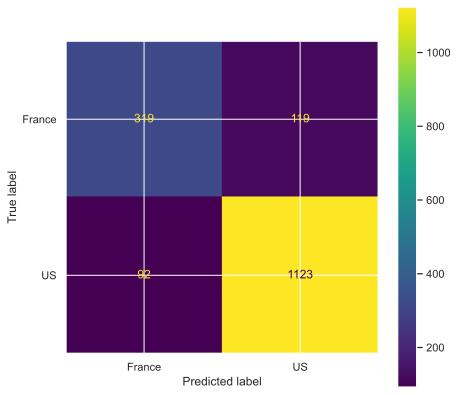

In [43]:
fig, ax = plt.subplots(figsize=(7, 7))
plot_confusion_matrix(logistic, X_test, y_test, ax=ax);

Let's go ahead and check the ROC curves and the AUC scores for the two difference classifiers.

In [53]:
y_test_bin = y_test.map({'France': 0, 'US': 1})
fpr, tpr, thresholds = roc_curve(y_test_bin, knn.predict_proba(X_test)[:,1])
fprlog, tprlog, thresholdslog = roc_curve(y_test_bin, logistic.predict_proba(X_test)[:,1])

KNN ROC AUC score =  0.921521318375707
Logit ROC AUC score =  0.9361313114230414


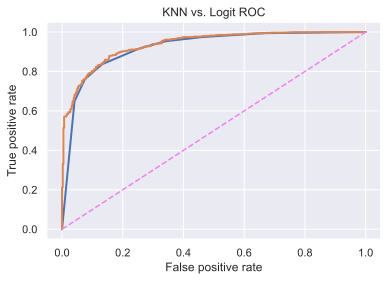

In [56]:
plt.plot(fpr, tpr,lw=2)
plt.plot(fprlog, tprlog,lw=2)
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])


plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('KNN vs. Logit ROC');
print("KNN ROC AUC score = ", roc_auc_score(y_test, knn.predict_proba(X_test)[:,1]))
print("Logit ROC AUC score = ", roc_auc_score(y_test, logistic.predict_proba(X_test)[:,1]))